In [34]:
# import libraries

import io, requests

import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio as rst
from rasterio.plot import show,show_hist
from rasterio.mask import mask

import matplotlib as mpl
from matplotlib import cm, colors
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [35]:
# function to load land datasets from drive
def getdf(link):
  req = requests.get(link).content
  return gpd.read_file(io.StringIO(req.decode('utf-8')))

# **Forest Boundaries**

In [37]:
# load the Terrestrial Ecoregions dataset
terr_ecoregions = "https://datasets.mojaglobal.workers.dev/0:/Bioclimatic&EcologicalZones/TerrestrialEcoregionsoftheWorld_WWF.geojson"
terr_ecoregions_df = getdf(terr_ecoregions)

In [64]:
# display all column names
pd.options.display.max_columns = None
terr_ecoregions_df.head(2)

,OBJECTID_1,OBJECTID,AREA,ECO_NAME,REALM,BIOME,ECO_NUM,ECO_ID,ECO_SYM,GBL_STAT,G200_REGIO,G200_NUM,G200_BIOME,G200_STAT,area_km2,eco_code,BIOME_1,GBL_STAT_1,REALM_1,Shape_Length,Shape_Area,geometry
0,1,1,29.802942,Northern Mesoamerican Pacific mangroves,NT,14,4,61404,119,1,,0,0,0,8174,NT1404,,,Neotropics,0.219475,0.002769,"POLYGON ((-112.30433 29.33480, -112.29035 29.3..."
1,2,2,11.977824,Northern Mesoamerican Pacific mangroves,NT,14,4,61404,119,1,,0,0,0,8174,NT1404,,,Neotropics,0.193289,0.001111,"POLYGON ((-112.19639 29.20719, -112.19669 29.2..."


In [68]:
# get a specific region
alsk_taiga = terr_ecoregions_df[terr_ecoregions_df['ECO_NAME']=='Alaska Peninsula montane taiga']

In [69]:
# get specific polygons of the region only
objectid=[6310, 6334, 6347, 6349, 6353, 6375, 6377, 6384, 6406, 6428, 6454, 6483, 6492, 6513,
               6517, 6522]

alsk_taiga_emerald=alsk_taiga[alsk_taiga['OBJECTID'].isin(objectid)]

In [66]:
# get specific regions
area=['British Columbia mainland coastal forests','Central and Southern Cascades forests','Central Pacific coastal forests',
      'Northern Pacific coastal forests','Pacific Coastal Mountain icefields and tundra','Puget lowland forests',
      'Queen Charlotte Islands','Willamette Valley forests']

emerald=terr_ecoregions_df[terr_ecoregions_df['ECO_NAME'].isin(area)]

In [74]:
# combine regions
emerald=pd.concat([alsk_taiga_emerald,emerald])

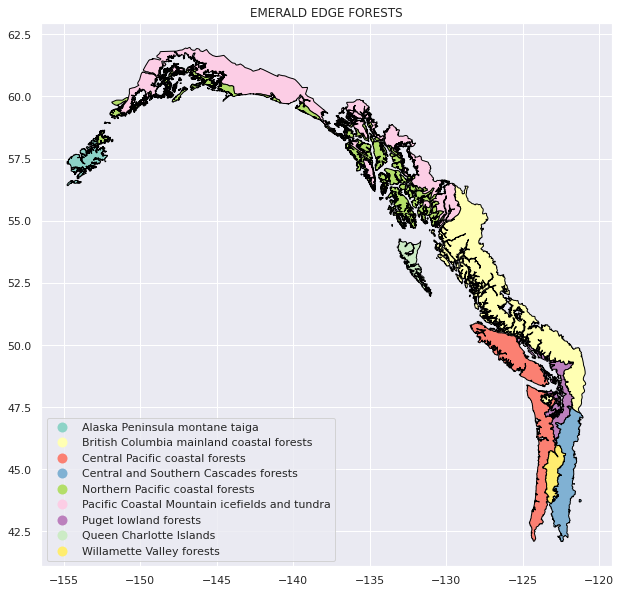

In [105]:
cmap='Set3'
fig,ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('EMERALD EDGE FORESTS')
emerald.plot(ax=ax,column='ECO_NAME',cmap=cmap,edgecolor='black',legend=True,legend_kwds= {'ncol': 1, 'loc': 'lower left'})
plt.show()

# **Holdridge Zones**

In [79]:
# load the Holdridge Lize Zones dataset
holdridge= 'https://datasets.mojaglobal.workers.dev/0:/Bioclimatic&EcologicalZones/HoldridgeLifeZones.json'
holdridge_df = getdf(holdridge)

In [80]:
# display column names
holdridge_df.head(2)

,FID,AREA,PERIMETER,HOLDRIG_,HOLDRIG_ID,ZONE,CASE_,FREQUENCY,DESC,SYMBOL,geometry
0,0,240.50,173,2,3695,1,2,13,Ice,5,"POLYGON ((-61.00000 81.00000, -61.50000 81.000..."
1,1,1.25,6,3,110,2,3,232,Polar desert,5,"POLYGON ((-80.50000 83.00000, -81.00000 83.000..."


In [81]:
# clip to forest boundaries
emerald_holdrige_df = holdridge_df.clip(emerald)
emerald_holdrige_df.shape

(97, 11)

In [82]:
# replace or delete empty rows
emerald_holdrige_df.DESC = emerald_holdrige_df.DESC.replace(r'^\s*$', 'Unspecified', regex=True)
emerald_holdrige_df=emerald_holdrige_df[emerald_holdrige_df['DESC']!='Unspecified']
emerald_holdrige_df.shape

(93, 11)

In [83]:
# display column names
emerald_holdrige_df.head(2)

,FID,AREA,PERIMETER,HOLDRIG_,HOLDRIG_ID,ZONE,CASE_,FREQUENCY,DESC,SYMBOL,geometry
1009,1009,2.00,8,1011,412,11,12,122,Boreal rain forest,20,"MULTIPOLYGON (((-127.50000 50.50000, -127.0000..."
1035,1035,0.25,2,1037,415,17,18,46,Cool temperate rain forest,110,"MULTIPOLYGON (((-127.00000 50.00000, -126.5000..."


In [84]:
# rename and change columns
emerald_holdrige_df.rename(columns={'DESC':'LifeZone'}, inplace=True)
emerald_holdrige_df.loc[:,'SYMBOL'] = 0
emerald_holdrige_df.rename(columns={'SYMBOL':'Age'}, inplace=True)
emerald_holdrige_df.head(2)

,FID,AREA,PERIMETER,HOLDRIG_,HOLDRIG_ID,ZONE,CASE_,FREQUENCY,LifeZone,Age,geometry
1009,1009,2.00,8,1011,412,11,12,122,Boreal rain forest,0,"MULTIPOLYGON (((-127.50000 50.50000, -127.0000..."
1035,1035,0.25,2,1037,415,17,18,46,Cool temperate rain forest,0,"MULTIPOLYGON (((-127.00000 50.00000, -126.5000..."


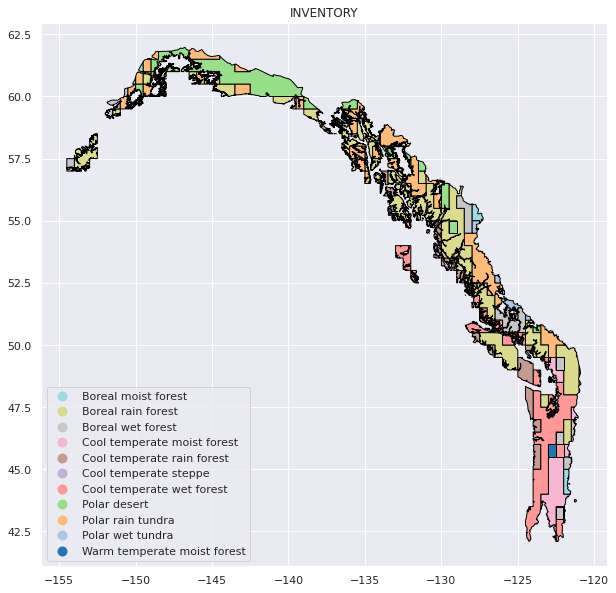

In [112]:
cmap='tab20_r'
fig,ax = plt.subplots(1,1,figsize=(15,10))
ax.set_title('INVENTORY')
emerald_holdrige_df.plot(ax=ax,column='LifeZone',cmap=cmap,edgecolor='black',legend=True,legend_kwds= {'ncol': 1, 'loc': 'lower left'})
plt.show()

# **Annual Mean Temperature**

In [114]:
# open tif file from folder
temp_rst = os.path.join('input', 'wc2.1_2.5m_bio_1.tif')
temp_img = rst.open(temp_rst)

In [115]:
# clip raster
out_temp, out_transform = mask(temp_img, [geom for geom in emerald.geometry], crop=True, pad=True)
out_meta = temp_img.meta

out_meta.update({"driver": "GTiff",
                 "height": out_temp.shape[1],
                 "width": out_temp.shape[2],
                 "transform": out_transform})

with rst.open(r'Emerald-BioClim2.5m_Temperature.tiff', 'w', **out_meta) as dest:
    dest.write(out_temp)

In [116]:
# load raster
forest_temp_rst = r'Emerald-BioClim2.5m_Temperature.tiff'
forest_temp_img = rst.open(forest_temp_rst)

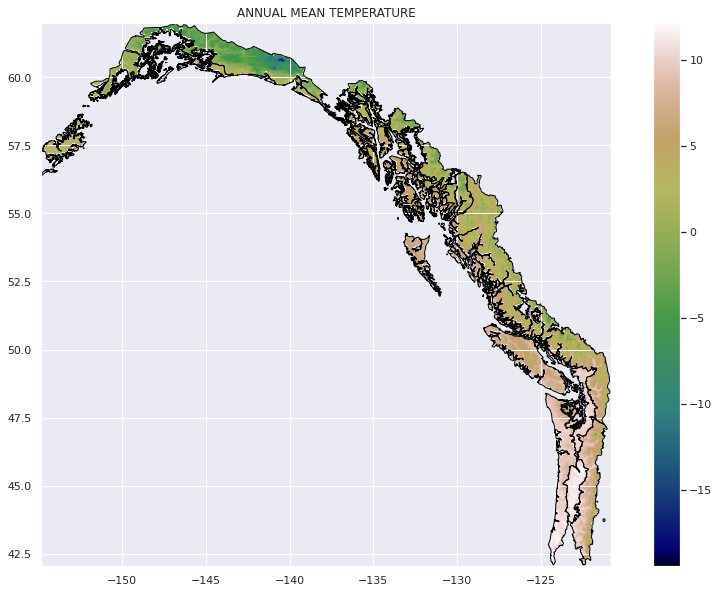

In [120]:
mpl.rc('image', cmap='gist_earth')

arr = forest_temp_img.read(1)
arr = np.where(arr < -20, np.nan, arr)

fig, ax = plt.subplots(1, 1, figsize=(15,10))

ax.set_title('ANNUAL MEAN TEMPERATURE')
show(arr, transform=forest_temp_img.transform, ax=ax)
emerald.plot(ax=ax,color='none',edgecolor='black',legend=True)

fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=np.nanmin(arr), vmax=np.nanmax(arr))), ax=ax)

plt.show()